In [1]:
# Checkout www.pygimli.org for more examples
%matplotlib inline


2D ERT modeling and inversion
-----------------------------


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
# pg.setTestingMode(True)
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

Create geometry definition for the modelling domain.

worldMarker=True indicates the default boundary conditions for the ERT



In [3]:
world = mt.createWorld(start=[-50, 0], end=[50, -50], layers=[-1, -5],
                       worldMarker=True)

Create some heterogeneous circular anomaly



In [4]:
block = mt.createCircle(pos=[-5, -3.], radius=[4, 1], marker=4,
                        boundaryMarker=10, area=0.1)

In [5]:
poly = mt.createPolygon([(1,-4), (2,-1.5), (4,-2), (5,-2),
                         (8,-3), (5,-3.5), (3,-4.5)], isClosed=True,
                         addNodes=3, interpolate='spline', marker=5)

Merge geometry definition into a Piecewise Linear Complex (PLC)



In [6]:
geom = world + block + poly

Optional: show the geometry



(<AxesSubplot:>, None)

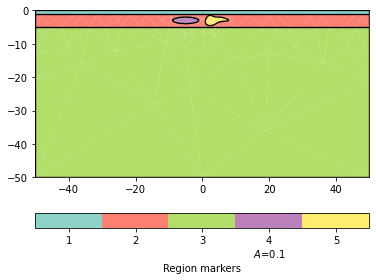

In [7]:
pg.show(geom)

Create a Dipole Dipole ('dd') measuring scheme with 21 electrodes.



In [19]:
scheme = ert.createERTData(elecs=np.linspace(start=-15, stop=15, num=21),
                           schemeName='pp')

ModuleNotFoundError: No module named 'pybert'

Put all electrode (aka sensors) positions into the PLC to enforce mesh
refinement. Due to experience, its convenient to add further refinement
nodes in a distance of 10% of electrode spacing to achieve sufficient
numerical accuracy.



C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\viewer\mpl\colorbar.py:434: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  mappable.get_cmap().set_bad([1.0, 1.0, 1.0, 0.0])


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x31ddd405c8>)

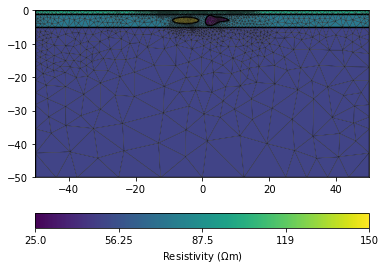

In [9]:
for p in scheme.sensors():
    geom.createNode(p)
    geom.createNode(p - [0, 0.1])

# Create a mesh for the finite element modelling with appropriate mesh quality.
mesh = mt.createMesh(geom, quality=34)

# Create a map to set resistivity values in the appropriate regions
# [[regionNumber, resistivity], [regionNumber, resistivity], [...]
rhomap = [[1, 100.],
          [2, 75.],
          [3, 50.],
          [4, 150.],
          [5, 25]]

# Take a look at the mesh and the resistivity distribution
pg.show(mesh, data=rhomap, label=pg.unit('res'), showMesh=True)

Perform the modeling with the mesh and the measuring scheme itself
and return a data container with apparent resistivity values,
geometric factors and estimated data errors specified by the noise setting.
The noise is also added to the data. Here 1% plus 1µV.
Note, we force a specific noise seed as we want reproducable results for
testing purposes.



In [10]:
data = ert.simulate(mesh, scheme=scheme, res=rhomap, noiseLevel=1,
                    noiseAbs=1e-6, seed=1337)

pg.warning(np.linalg.norm(data['err']), np.linalg.norm(data['rhoa']))
pg.info('Simulated data', data)
pg.info('The data contains:', data.dataMap().keys())

pg.info('Simulated rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))
pg.info('Selected data noise %(min/max)', min(data['err'])*100, max(data['err'])*100)

04/03/21 - 10:46:54 - pyGIMLi - WARNING - 0.13172116771358186 956.9335215375536
04/03/21 - 10:46:54 - pyGIMLi - INFO - Simulated data Data: Sensors: 21 data: 171, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']
04/03/21 - 10:46:54 - pyGIMLi - INFO - The data contains: ['a', 'b', 'err', 'i', 'ip', 'iperr', 'k', 'm', 'n', 'r', 'rhoa', 'u', 'valid']
04/03/21 - 10:46:54 - pyGIMLi - INFO - Simulated rhoa (min/max) 44.15373345316981 101.31460815873952
04/03/21 - 10:46:54 - pyGIMLi - INFO - Selected data noise %(min/max) 1.0000294836363899 1.0567844377657407


relativeError set to a value > 0.5 .. assuming this is a percentage Error level dividing them by 100
Data error estimate (min:max)  0.0100002948363639 : 0.010567844377657407


Optional: you can filter all values and tokens in the data container.
Its possible that there are some negative data values due to noise and
huge geometric factors. So we need to remove them.



04/03/21 - 10:46:54 - pyGIMLi - INFO - Filtered rhoa (min/max) 44.15373345316981 101.31460815873952


(<AxesSubplot:>, <matplotlib.colorbar.Colorbar at 0x31e1318608>)

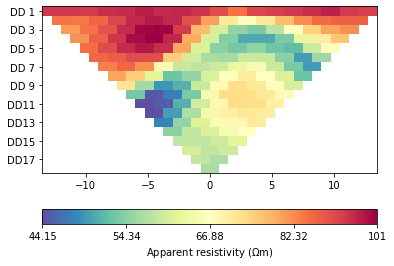

In [11]:
data.remove(data['rhoa'] < 0)
pg.info('Filtered rhoa (min/max)', min(data['rhoa']), max(data['rhoa']))

# You can save the data for further use
data.save('simple.dat')

# You can take a look at the data
ert.show(data)

Initialize the ERTManager, e.g. with a data container or a filename.




In [12]:
mgr = ert.ERTManager('simple.dat')

Run the inversion with the preset data. The Inversion mesh will be created
with default settings.



In [13]:
inv = mgr.invert(lam=20, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.6883, significant=1)

04/03/21 - 10:46:57 - pyGIMLi - INFO - Found 2 regions.
04/03/21 - 10:46:57 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
04/03/21 - 10:46:57 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/03/21 - 10:46:57 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
04/03/21 - 10:46:57 - pyGIMLi - INFO - Starting inversion.
04/03/21 - 10:46:57 - pyGIMLi - INFO - Set default startmodel to median(data values)=68.0345920476026
04/03/21 - 10:46:57 - pyGIMLi - INFO - Created startmodel from forward operator: 287 [68.0345920476026,...,68.0345920476026]


<class 'pygimli.physics.ert.ert.ERTManager'>.applyMesh(C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\frameworks\methodManager.py:647) : Mesh: Nodes: 266 Cells: 456 Boundaries: 721
fop: <pygimli.physics.ert.ert.ERTModelling object at 0x00000031DE6619F0>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x00000031DE661AB0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x00000031DE661830>
min/max (data): 44.15/101
min/max (error): 1.0%/1.06%
min/max (start model): 68.03/68.03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 4.19 (dPhi = 70.65%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 0.85 (dPhi = 65.93%) lam: 20.0


################################################################################
#                  Abort criterion rea

Let the ERTManger show you the model of the last successful run and how it
fits the data. Shows data, model response, and model.




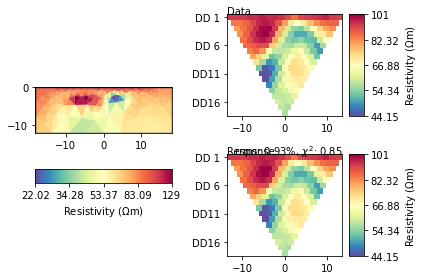

In [14]:
mgr.showResultAndFit()
meshPD = pg.Mesh(mgr.paraDomain) # Save copy of para mesh for plotting later

You can also provide your own mesh (e.g., a structured grid if you like them)




In [15]:
inversionDomain = pg.createGrid(x=np.linspace(start=-18, stop=18, num=33),
                                y=-pg.cat([0], pg.utils.grange(0.5, 8, n=8)),
                                marker=2)

The inversion domain for ERT problems needs a boundary that represents the
far regions in the subsurface of the halfspace.
Give a cell marker lower than the marker for the inversion region, the lowest
cell marker in the mesh will be the inversion boundary region by default.




In [16]:
grid = pg.meshtools.appendTriangleBoundary(inversionDomain, marker=1,
                                           xbound=50, ybound=50)

The Inversion can be called with data and mesh as argument as well




In [17]:
model = mgr.invert(data, mesh=grid, lam=20, verbose=True)
# np.testing.assert_approx_equal(mgr.inv.chi2(), 0.951027, significant=3)

04/03/21 - 10:47:03 - pyGIMLi - INFO - Found 2 regions.
04/03/21 - 10:47:03 - pyGIMLi - INFO - Region with smallest marker set to background (marker=1)
04/03/21 - 10:47:03 - pyGIMLi - INFO - Creating forward mesh from region infos.
04/03/21 - 10:47:03 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


<class 'pygimli.physics.ert.ert.ERTManager'>.applyMesh(C:\Users\Emerson\Anaconda3\envs\pg\lib\site-packages\pygimli\frameworks\methodManager.py:647) : Mesh: Nodes: 825 Cells: 1263 Boundaries: 2087


04/03/21 - 10:47:03 - pyGIMLi - INFO - Starting inversion.
04/03/21 - 10:47:03 - pyGIMLi - INFO - Set default startmodel to median(data values)=68.03459204760257
04/03/21 - 10:47:03 - pyGIMLi - INFO - Created startmodel from forward operator: 256 [68.03459204760257,...,68.03459204760257]


fop: <pygimli.physics.ert.ert.ERTModelling object at 0x00000031DE6619F0>
Data transformation: <pygimli.core._pygimli_.RTransLogLU object at 0x00000031DE661AB0>
Model transformation: <pygimli.core._pygimli_.RTransLog object at 0x00000031DE661830>
min/max (data): 44.15/101
min/max (error): 1.0%/1.06%
min/max (start model): 68.03/68.03
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 5.31 (dPhi = 91.89%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.3 (dPhi = 60.34%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.18 (dPhi = 4.13%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 5 ... chi² = 1.13 (dPhi = 2.06%) lam: 20.0
---------------------------------------------------

You can of course get access to mesh and model and plot them for your own.
Note that the cells of the parametric domain of your mesh might be in
a different order than the values in the model array if regions are used.
The manager can help to permutate them into the right order.




04/03/21 - 10:47:23 - pyGIMLi - INFO - Inversion stopped with chi² = 1.09


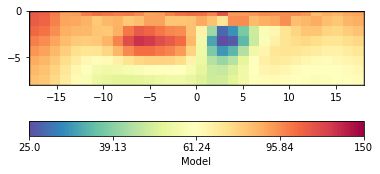

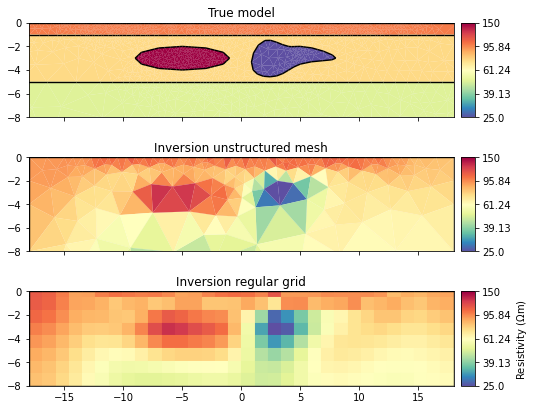

In [18]:
modelPD = mgr.paraModel(model)  # do the mapping
pg.show(mgr.paraDomain, modelPD, label='Model', cMap='Spectral_r',
        logScale=True, cMin=25, cMax=150)

pg.info('Inversion stopped with chi² = {0:.3}'.format(mgr.fw.chi2()))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, sharey=True, figsize=(8,7))

pg.show(mesh, rhomap, ax=ax1, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
pg.show(meshPD, inv, ax=ax2, hold=True, cMap="Spectral_r", logScale=True,
        orientation="vertical", cMin=25, cMax=150)
mgr.showResult(ax=ax3, cMin=25, cMax=150, orientation="vertical")

labels = ["True model", "Inversion unstructured mesh", "Inversion regular grid"]
for ax, label in zip([ax1, ax2, ax3], labels):
    ax.set_xlim(mgr.paraDomain.xmin(), mgr.paraDomain.xmax())
    ax.set_ylim(mgr.paraDomain.ymin(), mgr.paraDomain.ymax())
    ax.set_title(label)